In [1]:
import sys

SOFTWARE_DIR = '/sdf/data/neutrino/software/spine/src/' # Change this path to your software install
DATA_DIR = '/sdf/home/j/jessicam/Mx2/data/larcv/' # Change this path if you are not on SDF (see main README)

# Set software directory
sys.path.append(SOFTWARE_DIR)

In [2]:
from spine.io.read.hdf5 import HDF5Reader

reader = HDF5Reader('/n/holystore01/LABS/iaifi_lab/Users/jmicallef/tester.h5')

Welcome to JupyROOT 6.26/16


ModuleNotFoundError: No module named 'spine.io.read'

## Identify True & Predicted Track Matches for all entries

In [ ]:
from spine.utils.globals import GROUP_COL
from spine.utils.gnn.cluster import get_cluster_label
import numpy as np

number_clusters = []
label_mask = []
pred_mask = []
num_extra = []
num_missing = []
num_wrong = []
for entry in range(0, reader.num_entries):

    data = reader[entry]
    group_ids = get_cluster_label(data['data'], data['clusts'], column=GROUP_COL)
    number_clusters.append(len(group_ids))
    
    ###### True Match Cluster Segments ######
    # True if should be matched, false if shouldnt
    true_mask = (group_ids[data['edge_index'][:, 0]] == group_ids[data['edge_index'][:, 1]])
    label_mask.append(true_mask) 
    ###### Predicted0 Matched Cluster Segments #######
    # True if GNN matched, false if GNN didn't match
    gnn_mask = data['edge_pred'][:,1] > data['edge_pred'][:,0]
    pred_mask.append(gnn_mask)
    
    true_edge = data["edge_index"][true_mask]
    pred_edge = data['edge_index'][gnn_mask]

    set_true = set(map(tuple, true_edge))
    set_pred = set(map(tuple, pred_edge))
    common = set_true & set_pred
    true_only = set_true - set_pred
    pred_only = set_pred - set_true
    not_common = set_true ^ set_pred
    
    if len(true_only) > 0:
        num_missing.append(entry)
    if len(pred_only) > 0:
        num_extra.append(entry)
    if len(not_common) > 0:
        num_wrong.append(entry)

In [ ]:
## Takes some time ###
# Convert the concatenated array to a Python list for use later
label_array = np.concatenate(label_mask).ravel()
flattened_label = label_array.tolist()
prediction_array = np.concatenate(pred_mask).ravel()
flattened_pred = prediction_array.tolist()


## Create "Confusion Matrix" Counting How Often It Is Right/Wrong

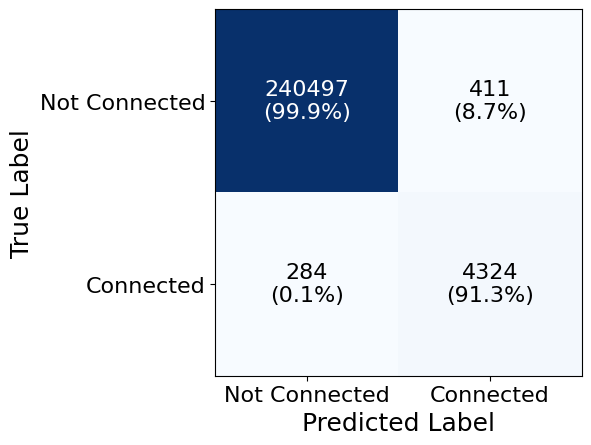

In [43]:
import sklearn
import matplotlib.pyplot as plt

con_mat = sklearn.metrics.confusion_matrix(flattened_label,flattened_pred)
#con_mat = sklearn.metrics.confusion_matrix(flattened_pred,flattened_label)
fig, ax = plt.subplots(figsize=(6, 6))
disp = sklearn.metrics.ConfusionMatrixDisplay(con_mat,display_labels=["Not Connected", "Connected"])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
for text in ax.texts:  # Remove the default text annotations
    text.set_visible(False)

# Annotate the confusion matrix with both count and percentage
sums = np.sum(con_mat, axis=0)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        count = con_mat[i, j]
        total = sums[j]
        percentage = 100 * count / total
        if count > (sums[0] + sums[1])*0.7: #Change color of text if background too dark
            textcolor = 'white'
        else:
            textcolor = 'black'
        ax.text(j, i, f'{count}\n({percentage:.1f}%)',
                ha='center', va='center', fontsize=16, color=textcolor)

# Increase font size of tick labels
plt.xticks(fontsize=16)  # Increase x-axis tick label size
plt.yticks(fontsize=16)  # Increase y-axis tick label size

# Increase font size of axis labels
ax.set_xlabel('Predicted Label', fontsize=18)  # Increase x-axis label size
ax.set_ylabel('True Label', fontsize=18)       # Increase y-axis label size
#ax.set_ylabel('Predicted Label', fontsize=18)  # Increase x-axis label size
#ax.set_xlabel('True Label', fontsize=18)       # Increase y-axis label size
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png",dpi=100,bbox_inches="tight",transparent=True)

## Plot One Spill Display

### Some functions to plot the output and bounding boxes for detectors

#### Bounding box for 2x2

In [24]:
import plotly.graph_objects as go

def add_3d_box(fig, x_min=-639.31, x_max=639.31, y_min=-620.76, y_max=620.76, z_min=-645.38, z_max=645.38):
    # Define the vertices of the box
    r = np.array([
        [x_min, y_min, z_min],
        [x_max, y_min, z_min],
        [x_max, y_max, z_min],
        [x_min, y_max, z_min],
        [x_min, y_min, z_max],
        [x_max, y_min, z_max],
        [x_max, y_max, z_max],
        [x_min, y_max, z_max]
    ])

    # Define the edges of the box
    edges = [
        [r[0], r[1], r[2], r[3], r[0]],  # Bottom face
        [r[4], r[5], r[6], r[7], r[4]],  # Top face
        [r[0], r[4]],  # Vertical edges
        [r[1], r[5]],
        [r[2], r[6]],
        [r[3], r[7]]
    ]

    # Create lines for the box
    for edge in edges:
        x_vals, y_vals, z_vals = zip(*edge)
        fig.add_trace(go.Scatter3d(
            x=x_vals, y=y_vals, z=z_vals,
            mode='lines',
            line=dict(color='black', width=2),
        ))

#### Bounding Box for MINERvA

In [25]:
def draw_minerva(fig,x_min =-1080.0, y_min = -1450.0, z_min = -2400.0,
                x_max = 1080.0, y_max = 1000.0, z_max = 3100.0,
                x_num=720 , y_num=817, z_num=1834):
    x_base = [0, 1080, 1080, 0, -1080, -1080]
    x_base = find_num_indices(x_base, x_min, x_max, x_num)
    shift = 2450
    y_base = [-3900 + shift, -3300 + shift, -2040 + shift, -1450 + shift, -2060 + shift, -3300 + shift]
    y_base = find_num_indices(y_base, y_min, y_max, y_num)
    
    z_base = {
        "ds": [1640, 3100],
        "us": [-2400, -1900]
    }
    z_base["ds"] = find_num_indices(z_base["ds"], z_min, z_max, z_num)
    z_base["us"] = find_num_indices(z_base["us"], z_min, z_max, z_num)


    # Plot the cylindrical hexagon
    for j in ["ds", "us"]:
        for i in range(len(x_base)):
            # Bottom face
            fig.add_trace(go.Scatter3d(
                x=[x_base[i], x_base[(i + 1) % len(x_base)]],
                y=[y_base[i], y_base[(i + 1) % len(x_base)]],
                z=[z_base[j][0], z_base[j][0]],
                mode='lines',
                line=dict(color='black'),
            ))

            # Top face
            fig.add_trace(go.Scatter3d(
                x=[x_base[i], x_base[(i + 1) % len(x_base)]],
                y=[y_base[i], y_base[(i + 1) % len(x_base)]],
                z=[z_base[j][1], z_base[j][1]],
                mode='lines',
                line=dict(color='black'),
            ))

            # Vertical edges
            fig.add_trace(go.Scatter3d(
                x=[x_base[i], x_base[i]],
                y=[y_base[i], y_base[i]],
                z=[z_base[j][0], z_base[j][1]],
                mode='lines',
                line=dict(color='black'),
            ))

        

### Plotting spine fragments and labels

In [21]:
import math
from spine.utils.globals import GROUP_COL
from spine.vis.network import network_topology
from spine.vis.layout import HIGH_CONTRAST_COLORS, layout3d

from plotly import graph_objs as go
from plotly.offline import iplot
import numpy as np
def plot_3D_viewer(entry):
    print("Entry ", entry)
    data = reader[entry]
    
    trace = []
    CB_color_cycle = ['#332288','#117733', '#44AA99', '#88CCEE', 
                          '#EA4040','#0B57CB','#D79ABB','#7D7A7A','#D0B58F']
    
    #Find predicted matches
    mask = data['edge_pred'][:,1] > data['edge_pred'][:,0]
    edge_index = data['edge_index'][mask]
    print("Predicted connection:")
    print(edge_index)
    
    #Print out if there is anything "wrong" with prediction
    group_ids = get_cluster_label(data['data'], data['clusts'], column=GROUP_COL)
    true_mask = (group_ids[data['edge_index'][:, 0]] == group_ids[data['edge_index'][:, 1]])
    real = data["edge_index"][true_mask]
    print("True connection:")
    print(real)
    
    #for e in edge_index:
    #    if e not in real:
    #        print("PREDICTION wrong", e)
    #for r in real:
    #    if r not in edge_index:
    #        print("Real connection missing, should have", r)
    
    ### This line does the actual plotting! ###
    trace+= local_network_topology(data['data'], data['clusts'], edge_index,clust_labels=group_ids,
                           edge_labels=None,
                           markersize=2, colorscale=CB_color_cycle,
                           name='')
            
    
    fig = go.Figure(data=trace,layout=layout3d())
    
    ## Translate MINERvA units to this plot in cm
    xmin = (-1080.0)
    ymin = (-1450.0)
    zmin = (-2400.0)
    xmax = (1080.0) 
    ymax = (1000.0) 
    zmax = (3100.0)
    offsetx, offsety, offsetz = 0.0, 218.33799743652344, 6913.0
    xnum = int(math.ceil(abs((xmin - xmax)/3)))
    ynum = int(math.ceil(abs((ymin - ymax)/3)))
    znum = int(math.ceil(abs((zmin - zmax)/3)))
    ## Define the original ticks and their corresponding new values ##
    original_xticks = np.linspace(0,xnum,5)
    new_xticks = np.linspace(xmin,xmax,5)/10 #make mm to cm
    original_yticks = np.linspace(0,ynum,10)
    new_yticks = np.linspace(ymin,ymax,10)/10 #make mm to cm
    original_zticks = np.linspace(0,znum,10)
    new_zticks = np.linspace(zmin,zmax,10)/10 #make mm to cm
    
    ## All plot formatting!
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                tickvals=original_xticks,  # Positions of the original ticks
                ticktext=[int(val) for val in new_xticks],  # New labels for each tick
                title=dict(
                    text="Horizontal Axis (cm)",
                    font=dict(
                        size=12)  # Adjust this value to move the label further away
                ),
                tickfont=dict(size=12), 
            ),
            yaxis=dict(
                tickvals=original_yticks,  # Positions of the original ticks
                ticktext=[int(val) for val in new_yticks],  # New labels for each tick
                title=dict(
                    text="Vertical Axis (cm)",
                    font=dict(
                        size=12)  # Adjust this value to move the label further away
                ),
                tickfont=dict(size=12),
            ),
            zaxis=dict(
                tickvals=original_zticks,  # Positions of the original ticks
                ticktext=[int(val) for val in new_zticks],  # New labels for each tick
                title=dict(
                    text="Beam Axis (cm)",
                    font=dict(
                        size=12)  # Adjust this value to move the label further away
                ),
                tickfont=dict(size=12),
            )
        ),
        margin=dict(l=200, r=50, b=100, t=0),
        scene_camera=dict(
            eye=dict(x=-2, y=0.2, z=0.087),  # Adjust eye position
            up=dict(x=-0, y=20, z=0)  # Set the 'y' axis as the vertical axis
        )
    )
    
    # Add 2x2 and MINERvA boxes to the plot
    x_2x2min=-639.31
    x_2x2max=639.31
    y_2x2min=-620.76
    y_2x2max=620.76
    z_2x2min=-645.38
    z_2x2max=645.38
    add_3d_box(fig,x_min=find_num_index(x_2x2min,xmin,xmax,xnum),x_max=find_num_index(x_2x2max,xmin,xmax,xnum),
               y_min=find_num_index(y_2x2min,ymin,ymax,ynum),y_max=find_num_index(y_2x2max,ymin,ymax,ynum),
               z_min=find_num_index(z_2x2min,zmin,zmax,znum),z_max=find_num_index(z_2x2max,zmin,zmax,znum))
    draw_minerva(fig)
    
    fig.update_layout(showlegend=False)
    iplot(fig)

In [ ]:
plot_3D_viewer(612)